c:\Users\abdob\.pyenv\pyenv-win\versions\3.10.10\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\abdob\.pyenv\pyenv-win\versions\3.10.10\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\abdob\.pyenv\pyenv-win\versions\3.10.10\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature n

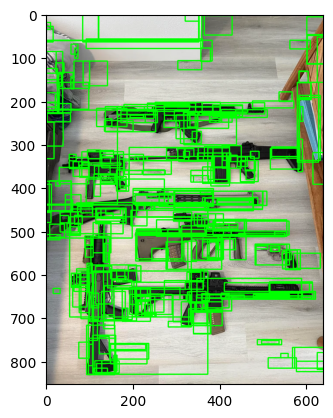

In [39]:
import cv2
import numpy as np
import pickle
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# Load the trained model from the pickle file
with open('random_forest.pkl', 'rb') as file:
    clf = pickle.load(file)

# Initialize OpenCV's selective search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def process_image(img):
    img = cv2.resize(img, (128, 128))  # Resize image to a standard size (128x128)
    edges = cv2.Canny(img, 100, 200)  # Canny edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    lbp = local_binary_pattern(gray, P=24, R=3, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    mean_val = np.mean(img)
    std_val = np.std(img)
    mean_edges = np.mean(edges)
    return [mean_val, std_val, mean_edges] + hist.tolist()

def merge_boxes(boxes):
    if not boxes:
        return []
    boxes = sorted(boxes, key=lambda x: x[2]*x[3], reverse=True)  # Sort boxes by area (w*h)
    merged_boxes = []
    while boxes:
        main_box = boxes.pop(0)
        x1, y1, w1, h1, _ = main_box
        new_boxes = []
        for box in boxes:
            x2, y2, w2, h2, _ = box
            # Check if the current box overlaps with the main_box
            if x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2:
                # Merge boxes
                nx = min(x1, x2)
                ny = min(y1, y2)
                nw = max(x1+w1, x2+w2) - nx
                nh = max(y1+h1, y2+h2) - ny
                main_box = (nx, ny, nw, nh, 'gun')
            else:
                new_boxes.append(box)
        merged_boxes.append(main_box)
        boxes = new_boxes
    return merged_boxes

# Load an image
img = cv2.imread('images RCNN test/2.png')
if img is None:
    raise Exception("The image path is incorrect or the file is not accessible")

ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
boxes = ss.process()

# Collect all regions with their classification
classified_boxes = []
for x, y, w, h in boxes[:500]:  # Limit the number of regions for efficiency
    region = img[y:y+h, x:x+w]
    features = process_image(region)
    prediction = clf.predict([features])
    classified_boxes.append((x, y, w, h, prediction[0]))

# Merge overlapping boxes
# filtered_boxes = merge_boxes(classified_boxes)

# clear all previous output
plt.clf()

# Draw the boxes
for x, y, w, h, pred in classified_boxes:
    if pred == "gun":
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [5]:
!python -m pip uninstall opencv-python -y
!python -m pip uninstall opencv-contrib-python -y
!python -m pip install opencv-contrib-python

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80


You can safely remove it manually.


  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
